In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append("../.venv/lib/python3.9/site-packages/")
sys.path.append("..")

In [2]:
from typing import Any, List

import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel, ttest_ind, norm
from sklearn.base import BaseEstimator
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

from coordination.model.beta_coordination_blending_latent_vocalics import BetaCoordinationBlendingLatentVocalics
from coordination.model.utils.coordination_blending_latent_vocalics import LatentVocalicsDataset
from coordination.model.utils.beta_coordination_blending_latent_vocalics import BetaCoordinationLatentVocalicsDataSeries
from scripts.formatting import set_size

In [3]:
PLOTS_DIR = "/Users/paulosoares/manuscript/experimental_agenda/figures"

def save_plot(fig: Any, name: str):
    fig.savefig(f"{PLOTS_DIR}/{name}.pdf", format='pdf', bbox_inches='tight')

In [35]:
def load_datasets(advisor: str):
    with open(f"/Users/paulosoares/data/study-3_2022/datasets/{advisor}/mission1_dataset.pkl", "rb") as f:
        mission1_dataset = pickle.load(f)
    
    with open(f"/Users/paulosoares/data/study-3_2022/datasets/{advisor}/mission2_dataset.pkl", "rb") as f:
        mission2_dataset = pickle.load(f)
    
    with open(f"/Users/paulosoares/data/study-3_2022/datasets/{advisor}/all_missions_dataset.pkl", "rb") as f:
        all_missions_dataset = pickle.load(f)
    
    return mission1_dataset, mission2_dataset, all_missions_dataset

def cohens_d(x1: np.ndarray, x2: np.ndarray):
    n1 = len(x1)
    n2 = len(x2)
    sp = np.sqrt(((n1 - 1) * np.var(x1) + (n2 - 1) * np.var(x2))/ (n1 + n2 - 2))
    
    return (np.mean(x1) - np.mean(x2)) / sp    

def compare_conditions(x1: np.ndarray, x2: np.ndarray, alternative: str = "greater", paired: bool = False):
    d = cohens_d(x1, x2)
    
    if paired:
        _, p_val = ttest_rel(x1, x2, alternative=alternative)
    else:
        _, p_val = ttest_ind(x1, x2, alternative=alternative)
    
    results = {
        "cohens_d": d, 
        "p_val": p_val
    }    
    
    return results

def team_process_scale_survey_score(series: BetaCoordinationLatentVocalicsDataSeries) -> float:
    return np.mean(np.array([value for value in series.team_process_surveys.values()]))

def team_satisfaction_survey_score(series: BetaCoordinationLatentVocalicsDataSeries) -> float:
    return np.mean(np.array([value for value in series.team_satisfaction_surveys.values()]))

In [36]:
# Loading all datasets
datasets = {
    "no_advisor": load_datasets("no_advisor"),
    "human_advisor": load_datasets("human_advisor"),
    "tomcat_advisor": load_datasets("tomcat_advisor")
}

In [79]:
dfs = []
for i in range(26):
    dfs.append(pd.read_csv(f"/Users/paulosoares/data/IJCAI_2023/minecraft/inference/no_advisor/2_features_no_link/2023-01-16/inference_table_{i}.csv", index_col=0))

no_inf_df = pd.concat(dfs)

inferences = {
    "no_advisor": no_inf_df
}

# Hypothesis Ia: Shuffled Conversation

The average coordination in real trials is greater than the average coordination in trials with sham conversations.

In [22]:
results_list = []

for condition in ["no_advisor", "tomcat_advisor"]:
    for model in models:
        for i, mission in enumerate(["mission2"]):#, "mission2"]):
            avg_coordinations = load_sham_inferences(condition, model["ref_date"], model["training_type"], mission)
            
            results_entry = model.copy()
            results_entry.update({
                "condition": condition,
                "mission": mission,
                "real_avg_coord": avg_coordinations[:, 0].mean(),
                "sham_avg_coord": avg_coordinations[:, 1].mean(),
                "real_std_coord": avg_coordinations[:, 0].std(),
                "sham_std_coord": avg_coordinations[:, 1].std(),             
            })
            results_entry.update(compare_conditions(avg_coordinations[:, 0], avg_coordinations[:, 1], paired=True))
            results_list.append(results_entry)

df_h1a = pd.DataFrame.from_dict(results_list)
df_h1a.head()

,ref_date,training_type,condition,mission,real_avg_coord,sham_avg_coord,real_std_coord,sham_std_coord,cohens_d,p_val
0,2022.12.07--18,single_execution_4_features,no_advisor,mission2,0.327737,0.325240,0.046890,0.049282,0.051924,0.362403
1,2022.12.07--18,single_execution_4_features,tomcat_advisor,mission2,0.351331,0.338753,0.060743,0.043987,0.237171,0.025750


# Hypothesis I: Predictive Power

Coordination is predictive of outcome measure ($M_i$). For each outcome measure, we train Bayesian linear model that tells us p($M_i$ | $C$) in a model with coordination and in a model without it. We then compute MSE and log-likelihood in a holdout set (using LOO) and report the average. We also compute how many times the model with coordination was better than the model without. We accept the hypothesis that the model with coordination is better than the one without if it is better 95% of the time.

In [49]:
class NullModel(BaseEstimator):
    
    def __init__(self):
        self.mean = None
        self.std = None
    
    def fit(self, X: np.ndarray, y: Any = None):
        self.mean = np.mean(y)
        self.std = np.std(y)
        return self
    
    def predict(self, X: np.ndarray):
        return np.ones(X.shape[0]) * self.mean
    
    def compute_log_likelihood(self, X: np.ndarray, y: np.ndarray, sample_weight=None):
        return norm(loc=self.mean, scale=self.std).logpdf(y)

class CoordinationModel(BaseEstimator):
    
    def __init__(self):
        self.reg = BayesianRidge(tol=1e-6, fit_intercept=True)
    
    def fit(self, X: np.ndarray, y: Any = None):
        self.reg.fit(X, y)
        return self
    
    def predict(self, X: np.ndarray):
        return self.reg.predict(X)
    
    def compute_log_likelihood(self, X: np.ndarray, y: np.ndarray, sample_weight=None):
        mean, std = self.reg.predict(X, return_std=True)
        return norm(loc=mean, scale=std).logpdf(y)

def execute_loo(X: np.ndarray, y: np.ndarray, plot: bool = False):
    null_model = NullModel()
    coord_model = CoordinationModel()
    null_mses = []
    null_nlls = []
    coord_mses = []
    coord_nlls = []
    
    loo = LeaveOneOut()
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        null_model.fit(X_train, y_train)
        null_mses.append(mean_squared_error(null_model.predict(X_test), y_test))
        null_nlls.append(-null_model.compute_log_likelihood(X_test, y_test)[0])   

        coord_model.fit(X_train, y_train)
        coord_mses.append(mean_squared_error(coord_model.predict(X_test), y_test))
        coord_nlls.append(-coord_model.compute_log_likelihood(X_test, y_test)[0])
        
        if plot:
            print(null_mses[-1])
            print(coord_mses[-1])
            fig = plt.figure()
            xs = np.linspace(0,1, 100)
            plt.scatter(X_train.flatten(), y_train)
            plt.scatter(X_test.flatten(), y_test, color="red")
            plt.plot(xs, null_model.predict(xs[:, np.newaxis]), label="Null")
            plt.plot(xs, coord_model.predict(xs[:, np.newaxis]), label="Coord")
            plt.legend()            
            plt.show()
    
    null_mses = np.array(null_mses)
    coord_mses = np.array(coord_mses)
    null_nlls = np.array(null_nlls)
    coord_nlls = np.array(coord_nlls)
    
    _, p_val_nll = ttest_rel(coord_nlls, null_nlls, alternative="less")
    _, p_val_mse = ttest_rel(coord_mses, null_mses, alternative="less")
    
    results = {
        "avg_mse_null": np.mean(null_mses),
        "std_mse_null": np.std(null_mses),
        "avg_nll_null": np.mean(null_nlls),
        "std_nll_null": np.std(null_nlls),
        "avg_mse_coord": np.mean(coord_mses),
        "std_mse_coord": np.std(coord_mses),
        "avg_nll_coord": np.mean(coord_nlls),
        "std_nll_coord": np.std(coord_nlls),    
        "p_coord_smaller_mse": (100.0 * np.sum(coord_mses < null_mses)) / len(coord_mses),
        "p_coord_smaller_nll": (100.0 * np.sum(coord_nlls < null_nlls)) / len(coord_nlls),
        "p_val_nll": p_val_nll,
        "p_val_mse": p_val_mse,
        "cohens_d_nll": cohens_d(coord_nlls, null_nlls),
        "cohens_d_mse": cohens_d(coord_mses, null_mses),
    }
    
    return results

In [85]:
outcome_measures_labels = ["Score", "Process Scale", "Satisfaction"]

results_list = []
# for condition in ["no_advisor", "human_advisor", "tomcat_advisor", "all_conditions"]:
for condition in ["no_advisor"]:#, "tomcat_advisor"]:
    for model in ["2_features_no_link"]:
        for i, mission in enumerate(["Mission 1", "Mission 2"]):
            dataset = datasets[condition][i]
            inf_df = inferences[condition]
            
            X = np.array([inf_df[inf_df["experiment_id"] == s.uuid]["avg_coordination_mean"].values[0] for s in dataset.series if s.uuid not in ["T000614", "T000624"]])[:, None]
            outcome_measures = [np.array([s.team_score for s in dataset.series if s.uuid not in ["T000614", "T000624"]]),
                                np.array([team_process_scale_survey_score(s) for s in dataset.series if s.uuid not in ["T000614", "T000624"]]),
                                np.array([team_satisfaction_survey_score(s) for s in dataset.series if s.uuid not in ["T000614", "T000624"]])]
            
            for j, outcome_measure in enumerate(outcome_measures):
                results_entry = {"model": model}
                results_entry.update({
                    "condition": condition,
                    "mission": mission,
                    "outcome_measure": outcome_measures_labels[j]
                })
                results_entry.update(execute_loo(X, outcome_measure))
                results_list.append(results_entry)

df_h1 = pd.DataFrame.from_dict(results_list)
df_h1.head()

,model,condition,mission,outcome_measure,avg_mse_null,std_mse_null,avg_nll_null,std_nll_null,avg_mse_coord,std_mse_coord,avg_nll_coord,std_nll_coord,p_coord_smaller_mse,p_coord_smaller_nll,p_val_nll,p_val_mse,cohens_d_nll,cohens_d_mse
0,2_features_no_link,no_advisor,Mission 1,Score,30865.289256,42360.147507,6.769778,1.241946,33357.723465,39458.097680,6.740285,0.874970,58.333333,41.666667,0.414612,0.754888,-0.027455,0.060888
1,2_features_no_link,no_advisor,Mission 1,Process Scale,0.230725,0.349627,0.908773,1.393337,0.246764,0.367539,0.968926,1.397869,50.000000,50.000000,0.673520,0.652662,0.043102,0.044717
2,2_features_no_link,no_advisor,Mission 1,Satisfaction,0.269862,0.329290,0.884899,0.891286,0.307078,0.417891,1.038845,1.042704,66.666667,33.333333,0.851073,0.755643,0.158715,0.098924
3,2_features_no_link,no_advisor,Mission 2,Score,17233.057851,16822.261897,6.371226,0.654255,17844.242397,17873.801356,6.401177,0.707639,41.666667,33.333333,0.830601,0.830601,0.043951,0.035215
4,2_features_no_link,no_advisor,Mission 2,Process Scale,0.199526,0.190186,0.687911,0.673979,0.207545,0.194605,0.715773,0.685279,66.666667,50.000000,0.830909,0.830723,0.040995,0.041674


In [84]:
df_h1[(df_h1["p_val_mse"] <= 0.1)]

,model,condition,mission,outcome_measure,avg_mse_null,std_mse_null,avg_nll_null,std_nll_null,avg_mse_coord,std_mse_coord,avg_nll_coord,std_nll_coord,p_coord_smaller_mse,p_coord_smaller_nll,p_val_nll,p_val_mse,cohens_d_nll,cohens_d_mse


# Hypothesis II: Increased coordination predicts higher outcome measures

Perform a p-test over samples from the posterior distribution of slopes and check if that is bigger than 0. Moreover, compute effect size using Cohen's d measurement.

In [65]:
def test_positive_slope(X: np.ndarray, y: np.ndarray, num_samples: int):
    reg = BayesianRidge(tol=1e-6, fit_intercept=True)
    reg.fit(X, y)
    
    mean = reg.coef_[0]
    std = np.sqrt(reg.sigma_.flatten()[0])
    slope_posterior = norm(loc=mean, scale=std)
    
    slope_samples = slope_posterior.rvs(num_samples)
    d = cohens_d(slope_samples, np.zeros(num_samples))
    _, p_val = ttest_ind(slope_samples, np.zeros(num_samples), alternative="greater")
    
    results = {
        "cohens_d": d, 
        "p_val": p_val
    }    
    
    return results

In [67]:
outcome_measures_labels = ["Score", "Process Scale", "Satisfaction"]

results_list = []
for condition in ["no_advisor", "human_advisor", "tomcat_advisor", "all_conditions"]:
    for model in models:
        for i, mission in enumerate(["Mission 1", "Mission 2", "All Missions"]):
            dataset = datasets[condition][i]
            inferences = load_model_inferences(condition, model["ref_date"], model["training_type"])            
            X = np.array([AGGR_FN(summary.coordination_mean) for summary in inferences[i]])[:, np.newaxis]
            outcome_measures = [np.array([s.team_score for s in dataset.series]),
                                np.array([team_process_scale_survey_score(s) for s in dataset.series]),
                                np.array([team_satisfaction_survey_score(s) for s in dataset.series])]
            
            for j, outcome_measure in enumerate(outcome_measures):
                results_entry = model.copy()
                results_entry.update({
                    "condition": condition,
                    "mission": mission,
                    "outcome_measure": outcome_measures_labels[j]
                })
                results_entry.update(test_positive_slope(X, outcome_measure, 10000))
                results_list.append(results_entry)

df_h2 = pd.DataFrame.from_dict(results_list)
df_h2.head()

,ref_date,training_type,condition,mission,outcome_measure,cohens_d,p_val
0,2022.12.02--15,single_execution,no_advisor,Mission 1,Score,-1.223812,1.000000e+00
1,2022.12.02--15,single_execution,no_advisor,Mission 1,Process Scale,-0.524373,1.000000e+00
2,2022.12.02--15,single_execution,no_advisor,Mission 1,Satisfaction,-0.886129,1.000000e+00
3,2022.12.02--15,single_execution,no_advisor,Mission 2,Score,1.555748,0.000000e+00
4,2022.12.02--15,single_execution,no_advisor,Mission 2,Process Scale,0.295013,6.510790e-96


In [69]:
df_h2[(df_h2["p_val"] <= 0.05)]
# df_h2[(df_h2["training_type"] == "single_execution")]

,ref_date,training_type,condition,mission,outcome_measure,cohens_d,p_val
3,2022.12.02--15,single_execution,no_advisor,Mission 2,Score,1.555748,0.000000e+00
4,2022.12.02--15,single_execution,no_advisor,Mission 2,Process Scale,0.295013,6.510790e-96
21,2022.12.04--22,single_execution_intensity_only,no_advisor,Mission 2,Score,2.005155,0.000000e+00
22,2022.12.04--22,single_execution_intensity_only,no_advisor,Mission 2,Process Scale,2.494511,0.000000e+00
23,2022.12.04--22,single_execution_intensity_only,no_advisor,Mission 2,Satisfaction,0.479440,2.778845e-245
39,2022.12.07--18,single_execution_4_features,no_advisor,Mission 2,Score,2.206827,0.000000e+00
40,2022.12.07--18,single_execution_4_features,no_advisor,Mission 2,Process Scale,2.090382,0.000000e+00
41,2022.12.07--18,single_execution_4_features,no_advisor,Mission 2,Satisfaction,1.779357,0.000000e+00
49,2022.12.02--15,single_execution,human_advisor,Mission 2,Process Scale,0.036724,4.710295e-03
64,2022.12.04--22,single_execution_intensity_only,human_advisor,Mission 1,Process Scale,1.699480,0.000000e+00


# Hypothesis III: Intervening on team communication predicts higher coordination and outcome measures


Compare mission by mission whether ToMCAT trials had higher coordination and outcome measures than others.

In [70]:
outcome_measures_labels = ["Score", "Process Scale", "Satisfaction"]

# Compare the second group against the first
groups = [
    ("no_advisor", "human_advisor"),
    ("no_advisor", "tomcat_advisor"),
    ("human_advisor", "tomcat_advisor"),
]

results_list = []
for model in models:
    for i, mission in enumerate(["Mission 1", "Mission 2", "All Missions"]):
        for condition1, condition2 in groups:
            dataset1 = datasets[condition1][i]
            inferences1 = load_model_inferences(condition1, model["ref_date"], model["training_type"])            
            coord1 = np.array([AGGR_FN(summary.coordination_mean) for summary in inferences1[i]])

            dataset2 = datasets[condition2][i]
            inferences2 = load_model_inferences(condition2, model["ref_date"], model["training_type"])            
            coord2 = np.array([AGGR_FN(summary.coordination_mean) for summary in inferences2[i]])
            
            # Comparing coordination. Outcome measures were compared in another notebook.
            results_entry = model.copy()
            results_entry.update({
                "condition1": condition1,
                "condition2": condition2,
                "mission": mission
            })
            results_entry.update(compare_conditions(coord2, coord1))
            results_list.append(results_entry)

df_h3 = pd.DataFrame.from_dict(results_list)
df_h3.head()

,ref_date,training_type,condition1,condition2,mission,cohens_d,p_val
0,2022.12.02--15,single_execution,no_advisor,human_advisor,Mission 1,0.417236,0.169232
1,2022.12.02--15,single_execution,no_advisor,tomcat_advisor,Mission 1,-0.469895,0.858814
2,2022.12.02--15,single_execution,human_advisor,tomcat_advisor,Mission 1,-0.858316,0.971741
3,2022.12.02--15,single_execution,no_advisor,human_advisor,Mission 2,0.183384,0.322004
4,2022.12.02--15,single_execution,no_advisor,tomcat_advisor,Mission 2,0.631356,0.063705


In [71]:
df_h3[(df_h3["p_val"] <= 0.05)]

,ref_date,training_type,condition1,condition2,mission,cohens_d,p_val
9,2022.12.04--12,single_execution_no_self_dep,no_advisor,human_advisor,Mission 1,2.477402,3.801952e-06
12,2022.12.04--12,single_execution_no_self_dep,no_advisor,human_advisor,Mission 2,2.464285,5.960741e-07
15,2022.12.04--12,single_execution_no_self_dep,no_advisor,human_advisor,All Missions,1.993851,2.512024e-09
31,2022.12.05--09,single_execution_pitch_only,no_advisor,tomcat_advisor,Mission 2,1.174353,3.551000e-03
32,2022.12.05--09,single_execution_pitch_only,human_advisor,tomcat_advisor,Mission 2,1.035420,7.943231e-03
33,2022.12.05--09,single_execution_pitch_only,no_advisor,human_advisor,All Missions,0.484474,4.646555e-02
34,2022.12.05--09,single_execution_pitch_only,no_advisor,tomcat_advisor,All Missions,0.640605,1.478351e-02
42,2022.12.07--18,single_execution_4_features,no_advisor,human_advisor,All Missions,0.516442,3.692018e-02


## Hypothesis IV: Coordination in the second mission is higher than in the first mission

In [72]:
def get_paired_coordination(mission1_dataset: LatentVocalicsDataset, mission2_dataset: LatentVocalicsDataset, 
                            mission1_coordination: np.ndarray, mission2_coordination: np.ndarray):
    """
    Gets coordination for the same teams in mission 1 and 2. Ignores data from
    trials with only one mission.
    """
    
    mission1 = {}
    mission2 = {}
    mission1_trial_numbers = []
    
    for i in range(mission1_dataset.num_trials):
        mission_trial_number = int(mission1_dataset.series[i].uuid[1:])
        mission1[mission_trial_number] = mission1_coordination[i]
        
    for i in range(mission2_dataset.num_trials):
        mission_trial_number = int(mission2_dataset.series[i].uuid[1:])
        if mission_trial_number - 1 in mission1:
            # Only add if exists an entry for mission 1
            mission1_trial_numbers.append(mission_trial_number - 1)
        
            mission2[mission_trial_number] = mission2_coordination[i]
    
    coord1 = []
    coord2 = []
    for mission1_trial_number in mission1_trial_numbers:
        coord1.append(mission1[mission1_trial_number])
        coord2.append(mission2[mission1_trial_number + 1])
    
    return np.array(coord1), np.array(coord2)

In [73]:
results_list = []
for model in models:    
    for condition in ["no_advisor", "human_advisor", "tomcat_advisor", "all_conditions"]:
        inferences = load_model_inferences(condition, model["ref_date"], model["training_type"])            
        
        dataset1 = datasets[condition][0]
        dataset2 = datasets[condition][1]
        coord1 = np.array([AGGR_FN(summary.coordination_mean) for summary in inferences[0]])          
        coord2 = np.array([AGGR_FN(summary.coordination_mean) for summary in inferences[1]])        
        
        coord1, coord2 = get_paired_coordination(dataset1, dataset2, coord1, coord2)
        
        # Comparing coordination. Outcome measures were compared in another notebook.
        results_entry = model.copy()
        results_entry.update({
            "condition": condition
        })
        
        results_entry.update(compare_conditions(coord2, coord1, paired=True))
        results_list.append(results_entry)

df_h4 = pd.DataFrame.from_dict(results_list)
df_h4.head()

,ref_date,training_type,condition,cohens_d,p_val
0,2022.12.02--15,single_execution,no_advisor,-0.600152,0.957793
1,2022.12.02--15,single_execution,human_advisor,-0.876517,0.996158
2,2022.12.02--15,single_execution,tomcat_advisor,0.689078,0.051727
3,2022.12.02--15,single_execution,all_conditions,-0.044276,0.574790
4,2022.12.04--12,single_execution_no_self_dep,no_advisor,-0.990994,0.985384


In [74]:
df_h4[(df_h4["p_val"] <= 0.05)]

,ref_date,training_type,condition,cohens_d,p_val
6,2022.12.04--12,single_execution_no_self_dep,tomcat_advisor,0.853623,0.037096
14,2022.12.05--09,single_execution_pitch_only,tomcat_advisor,1.026324,0.027777


In [3]:
A = np.random.rand(2, 10)

In [4]:
A

array([[0.20360883, 0.1454761 , 0.00144894, 0.61628903, 0.46585692,
        0.30834115, 0.76083662, 0.42850829, 0.6843921 , 0.42321538],
       [0.09693469, 0.2510896 , 0.52525784, 0.34306378, 0.6086135 ,
        0.30203324, 0.8651043 , 0.07141722, 0.01209507, 0.92853079]])

In [5]:
A[:, [0,2,4,7]]

array([[0.20360883, 0.00144894, 0.46585692, 0.42850829],
       [0.09693469, 0.52525784, 0.6086135 , 0.07141722]])

In [32]:
df = pd.read_csv("/Users/paulosoares/data/IJCAI_2023/minecraft/inference/no_advisor/mission1/2_features_no_link/2023-01-16/inference_table_0.csv")
df.head()

,Unnamed: 0,experiment_id,coordination_means,coordination_stds,avg_coordination_mean,avg_coordination_std
0,0,T000613,"[0.16895652059330768, 0.18485861580915663, 0.1...","[0.22927717943389897, 0.26491741553042564, 0.2...",0.297546,0.339793


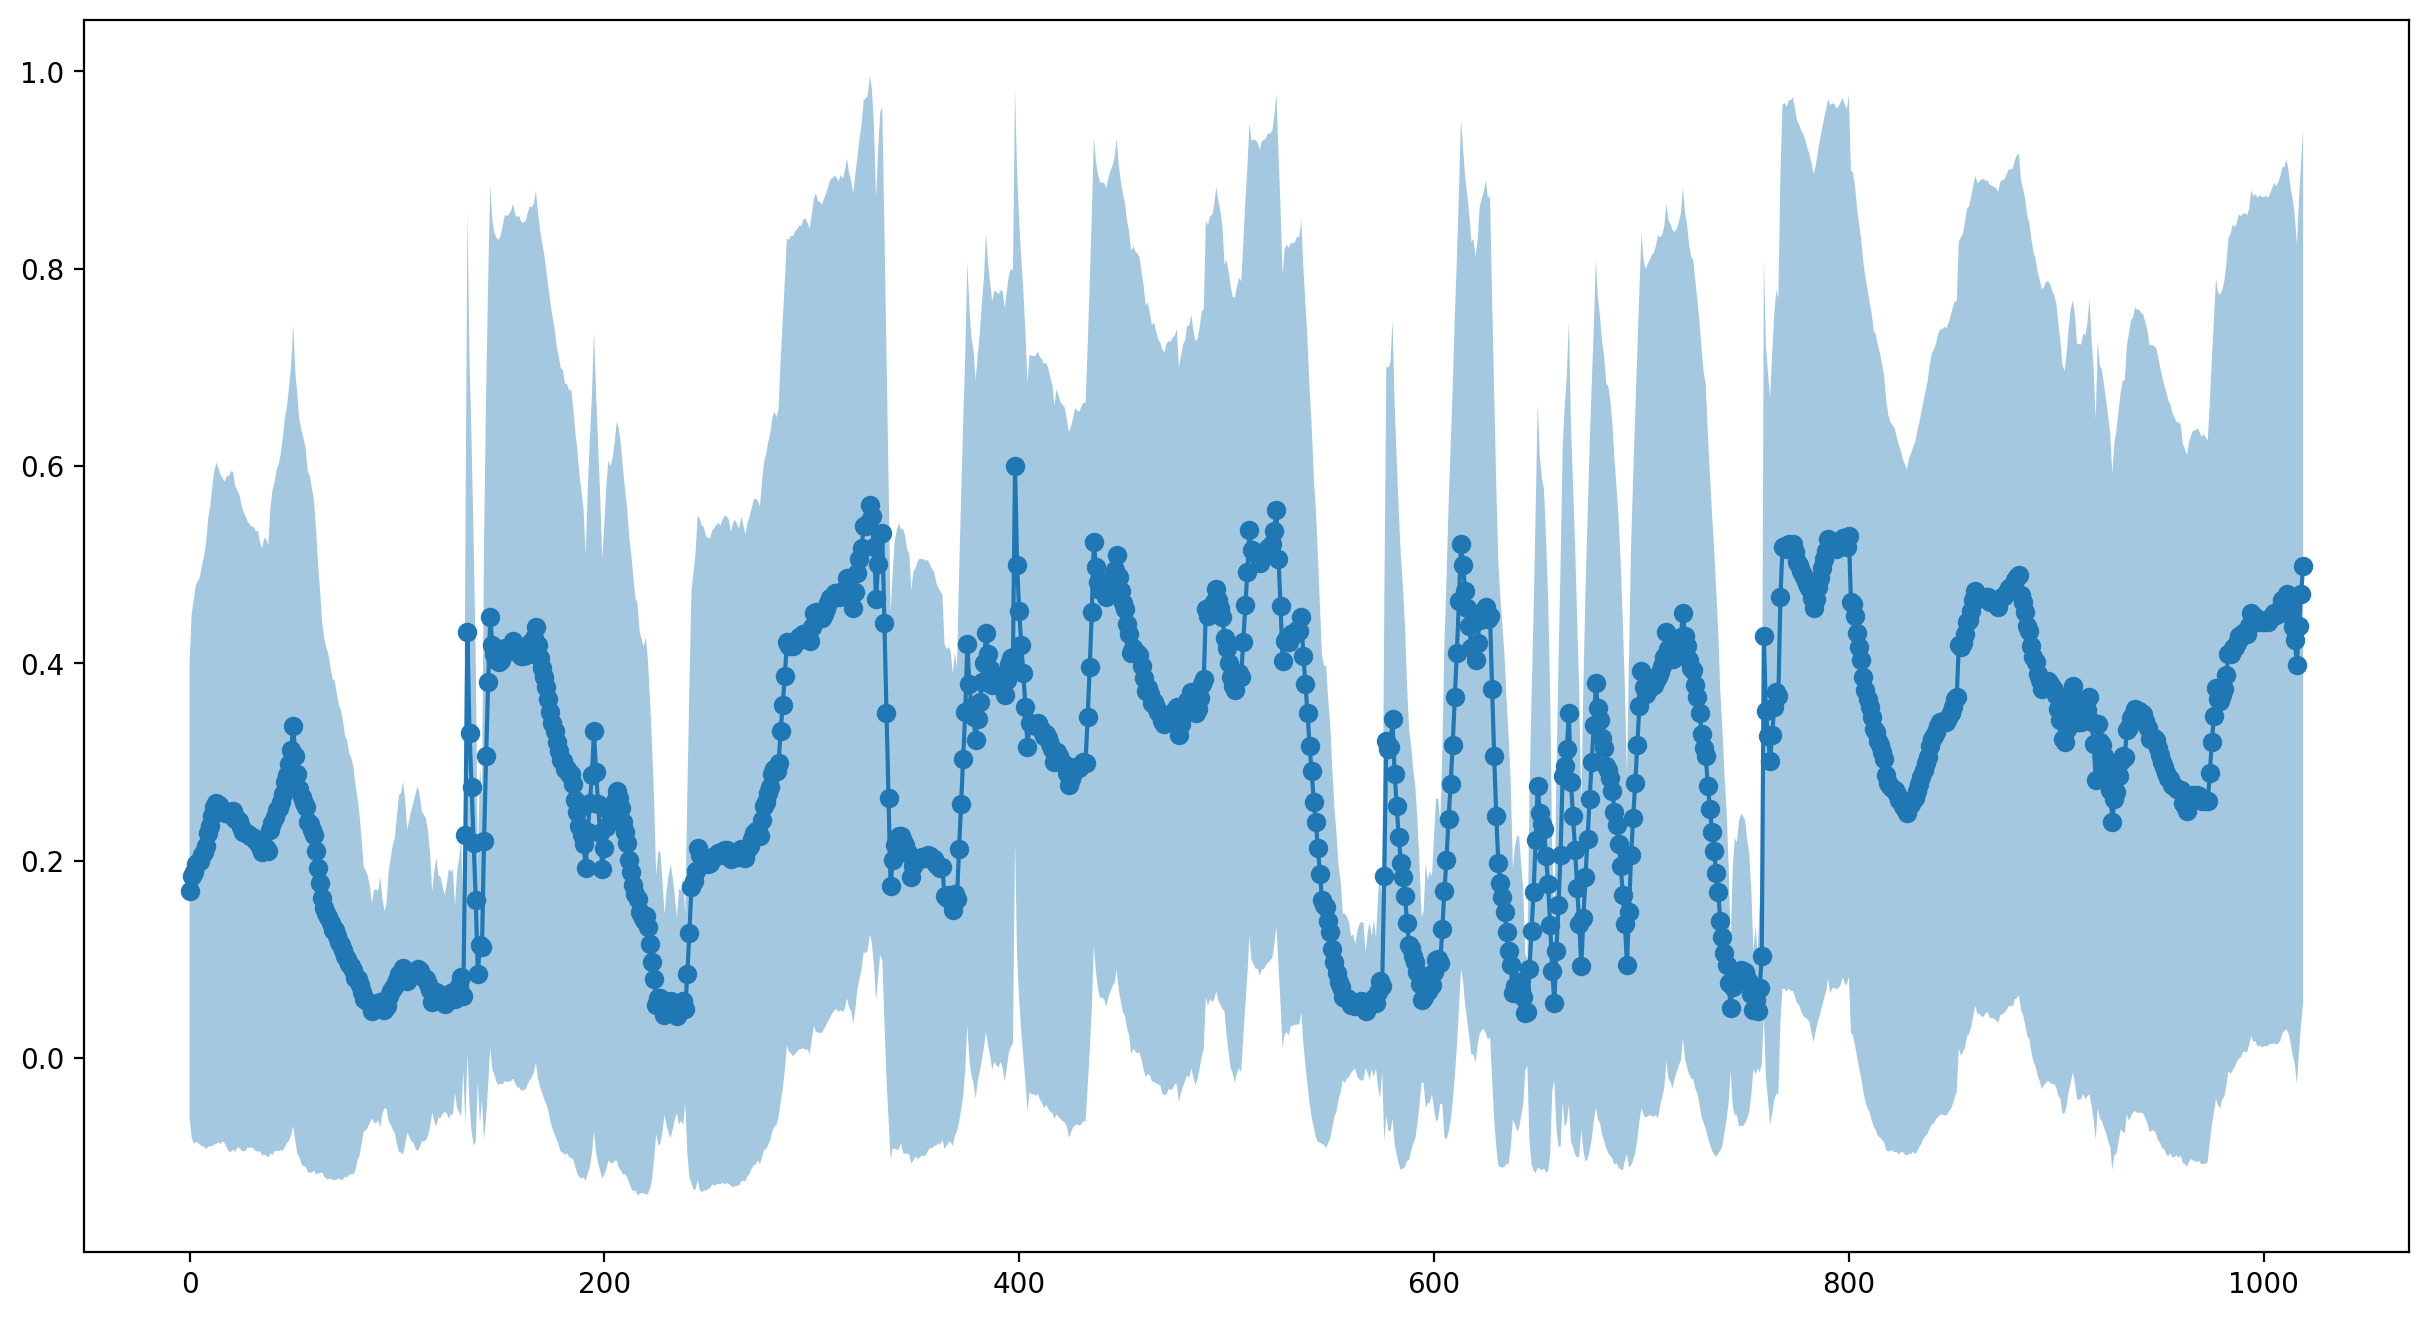

In [34]:
from ast import literal_eval

plt.figure(figsize=(15,8))
means = np.array(literal_eval(df["coordination_means"].values[0]))
stds = np.array(literal_eval(df["coordination_stds"].values[0]))
plt.plot(range(len(means)), means, marker="o")
plt.fill_between(range(len(means)), means - stds, means + stds, alpha=0.4)

In [30]:
import arviz as az

with open("/Users/paulosoares/data/IJCAI_2023/minecraft/inference/no_advisor/mission1/2_features_no_link/2023.01.16/inference_data_0.pkl", "rb") as f:
    idata = pickle.load(f)

az.plot_trace(idata[0], var_names=["sd_uc", "sd_c", "sd_vocalics", "sd_obs_vocalics"])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/paulosoares/data/IJCAI_2023/minecraft/inference/no_advisor/mission1/2_features_no_link/2023.01.16/inference_data_0.pkl'